In [2]:
import curvedsky
import sys
sys.path.append('../')
from matplotlib.pyplot import *

In [3]:
import numpy as np
import healpy as hp
import os
from tqdm import tqdm

In [4]:
%load_ext autoreload
%autoreload 2
from lat_cb.signal import LATsky,CMB
from lat_cb import mpi

In [5]:
class QE:
    def __init__(self,libdir,nside,alpha,dust,synch,beta):
        self.lat = LATsky(libdir,nside,alpha,dust,synch,beta)
        
        self.nside = nside

In [6]:
Tcmb  = 2.726e6    # CMB temperature
lmax  = 2048       # maximum multipole of output normalization
rlmin = 100
rlmax = 2048      # reconstruction multipole range
sig   = 10.
Acb   = 1e-5 # signal
ac2rad = np.pi/180./60.
L = np.linspace(0,lmax,lmax+1)
nside = 2048

In [26]:
lib = '/pscratch/sd/l/lonappan/SOLAT'
cmb = CMB(lib,2048,0.6)

In [27]:
lcl = cmb.get_lensed_spectra(dl=False,dtype='a').T/Tcmb**2

In [28]:
nl  = np.zeros((4,lmax+1))
#nl[0,:] = (sig*ac2rad/Tcmb)**2
#nl[1,:] = 2*nl[0,:]
#nl[2,:] = 2*nl[0,:]
ocl = lcl[:,:lmax+1] + nl

In [29]:
Al = np.zeros((2,lmax+1))
Al[0,:] = curvedsky.norm_quad.qeb('rot',lmax,rlmin,rlmax,lcl[1,:rlmax+1],ocl[1,:rlmax+1],ocl[2,:rlmax+1])[0]
Al[1,:] = curvedsky.norm_quad.qtb('rot',lmax,rlmin,rlmax,lcl[3,:rlmax+1],ocl[0,:rlmax+1],ocl[2,:rlmax+1])[0]

In [30]:
Fl = np.zeros((3,lmax+1,lmax+1))
for l in range(rlmin,rlmax):
    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]

In [39]:
Q, U = cmb.get_cb_lensed_QU(1)

In [42]:
Ealm, Balm = curvedsky.utils.hp_map2alm_spin(nside,lmax,lmax,2,Q/Tcmb,U/Tcmb)

In [43]:
Ealm *= Fl[1,:,:]
Balm *= Fl[2,:,:]

In [44]:
alm = curvedsky.rec_rot.qeb(lmax,rlmin,rlmax,lcl[1,:rlmax+1],Ealm,Balm)

 compute polarization rotation


In [45]:
alm *= Al[0][:,None]

In [46]:
cl = curvedsky.utils.alm2cl(lmax,alm,alm)

In [47]:
cl

array([0.00000000e+00, 7.81794020e-09, 4.02984934e-09, ...,
       4.16849454e-09, 4.18160673e-09, 4.06093160e-09])

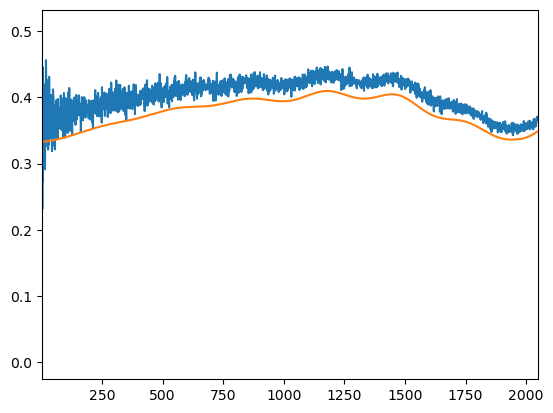

In [48]:
xlim(2,lmax)
plot(L,np.rad2deg(np.sqrt(cl*10**4)))
plot(np.rad2deg(np.sqrt(Al[0]*10**4)))

In [1]:
import numpy as np